<a href="https://colab.research.google.com/github/NiklasTR/DiffDock/blob/main/DiffDock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiffDock
Dock a PDB files and a SMILES with [DiffDock](https://github.com/gcorso/DiffDock).

Select Runtime / Run all to run an example PDB file and SMILES.

v2 improvements:
- works on proteins >1000 aas (with flag added to extract.py)
- works on standard GPU (by reducing batch size from 10 to 6)
- works with AlphaFold ids (AF-...) as well as PDB ids
- works with comma-delimited PDB_ids and/or SMILES
- runs smina to generate affinities (as DiffDock posed, or with smina minimization)
- shows results in a py3DMol view

colab by [@btnaughton](https://twitter.com/btnaughton)

In [35]:
#@title PDB + SMILES input

PDB_id = '6ej2' #@param {type:"string"}
SMILES_or_pubchem_id = 'CCCCNC(=O)[C@H](C)C[C@H](O)[C@@H]2C[C@H](C)CCCCCN(CC)C(=O)c1cc(cc(c1)C(=O)N2)OCC' #@param {type:"string"}

#@markdown Download a tar file containing all results?
download_results = True #@param {type:"boolean"}

In [36]:
import os
import requests
import time
from random import random

def download_pdb_file(pdb_id: str) -> str:
    """Download pdb file as a string from rcsb.org"""
    PDB_DIR ="/tmp/pdb/"
    os.makedirs(PDB_DIR, exist_ok=True)

    # url or pdb_id
    if pdb_id.startswith('http'):
        url = pdb_id
        filename = url.split('/')[-1]
    elif pdb_id.endswith(".pdb"):
        return pdb_id
    else:
        if pdb_id.startswith("AF"):
            url = f"https://alphafold.ebi.ac.uk/files/{pdb_id}-model_v3.pdb"
        else:
            url = f"http://files.rcsb.org/view/{pdb_id}.pdb"
        filename = f'{pdb_id}.pdb'

    cache_path = os.path.join(PDB_DIR, filename)
    if os.path.exists(cache_path):
        return cache_path

    pdb_req = requests.get(url)
    pdb_req.raise_for_status()
    open(cache_path, 'w').write(pdb_req.text)
    return cache_path

def download_smiles_str(pubchem_id: str, retries:int = 2) -> str:
    """Given a pubchem id, get a smiles string"""
    while True:
        req = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{pubchem_id}/property/CanonicalSMILES/CSV")
        smiles_url_csv = req.text if req.status_code == 200 else None
        if smiles_url_csv is not None:
            break
        if retries == 0:
            return None
        time.sleep(1+random())
        retries -= 1

    return smiles_url_csv.splitlines()[1].split(',')[1].strip('"').strip("'") if smiles_url_csv is not None else None

In [37]:
if not PDB_id or not SMILES_or_pubchem_id:
    PDB_id = "6agt"
    SMILES_or_pubchem_id = "COc(cc1)ccc1C#N"
    print(f"No input supplied. Using example data: {PDB_id} and {SMILES_or_pubchem_id}")

# to run many PDB+smiles at once, fill in a list of PDB_files and smiles here...
pdb_files = [download_pdb_file(_PDB_id) for _PDB_id in PDB_id.split(",")]
smiless = [download_smiles_str(_SMILES_or_pubchem_id) if str(_SMILES_or_pubchem_id).isnumeric() else _SMILES_or_pubchem_id
           for _SMILES_or_pubchem_id in SMILES_or_pubchem_id.split(',') ]

with open("/tmp/input_protein_ligand.csv", 'w') as out:
    out.write("protein_path,ligand\n")
    for pdb_file in pdb_files:
        for smiles in smiless:
            out.write(f"{pdb_file},{smiles}\n")

## Importing data from D3R Challenge

In [38]:
# write the ligand protein table manually with the D3R Challenge data, which I pinned to IPFS
!wget https://bafybeicvasvyesjr4fc4kjpirge26h3tyrxmp4ouvhufdgfbmgi6qpaiku.ipfs.dweb.link/BACE1/BACE_score_compounds_D3R_GC4_answers.csv #BACE1
!pwd

--2022-12-18 15:29:21--  https://bafybeicvasvyesjr4fc4kjpirge26h3tyrxmp4ouvhufdgfbmgi6qpaiku.ipfs.dweb.link/BACE1/BACE_score_compounds_D3R_GC4_answers.csv
Resolving bafybeicvasvyesjr4fc4kjpirge26h3tyrxmp4ouvhufdgfbmgi6qpaiku.ipfs.dweb.link (bafybeicvasvyesjr4fc4kjpirge26h3tyrxmp4ouvhufdgfbmgi6qpaiku.ipfs.dweb.link)... 209.94.90.1, 2602:fea2:2::1
Connecting to bafybeicvasvyesjr4fc4kjpirge26h3tyrxmp4ouvhufdgfbmgi6qpaiku.ipfs.dweb.link (bafybeicvasvyesjr4fc4kjpirge26h3tyrxmp4ouvhufdgfbmgi6qpaiku.ipfs.dweb.link)|209.94.90.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14351 (14K) [text/csv]
Saving to: ‘BACE_score_compounds_D3R_GC4_answers.csv.2’

BACE_score_compound 100%[===================>]  14.01K  --.-KB/s    in 0s      

2022-12-18 15:29:21 (241 MB/s) - ‘BACE_score_compounds_D3R_GC4_answers.csv.2’ saved [14351/14351]

/content


In [39]:
import pandas as pd
df = pd.read_csv("/content/BACE_score_compounds_D3R_GC4_answers.csv")
df["protein_path"] = "/tmp/pdb/6ej2.pdb	"
df["ligand"] = df['SMILES']
df = df[["protein_path", "ligand"]]
df.head(5)
df.head(5).to_csv("/tmp/input_protein_ligand.csv")

In [4]:
# clear out old results if running multiple times -- hopefully they have been downloaded already
!rm -rf /content/DiffDock/results

## Install prerequisites

In [5]:
!pip install ipython-autotime --quiet
%load_ext autotime

     |████████████████████████████████| 1.6 MB 47.7 MB/s 
time: 523 µs (started: 2022-12-18 13:33:56 +00:00)


In [6]:
if not os.path.exists("/content/DiffDock"):
    %cd /content
    !git clone https://github.com/gcorso/DiffDock.git
    %cd /content/DiffDock
    !git checkout a6c5275 # remove/update for more up to date code

/content
Cloning into 'DiffDock'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 211 (delta 73), reused 64 (delta 60), pack-reused 119
Receiving objects: 100% (211/211), 153.24 MiB | 17.42 MiB/s, done.
Resolving deltas: 100% (104/104), done.
/content/DiffDock
Note: checking out 'a6c5275'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at a6c5275 remove debugging raise in the inference file
time: 12 s (started: 2022-12-18 13:33:56 +00:00)


In [7]:
try:
    import biopandas
    import torch
except:
    !pip install pyg==0.7.1 --quiet
    !pip install pyyaml==6.0 --quiet
    !pip install scipy==1.7.3 --quiet
    !pip install networkx==2.6.3 --quiet
    !pip install biopython==1.79 --quiet
    !pip install rdkit-pypi==2022.03.5 --quiet
    !pip install e3nn==0.5.0 --quiet
    !pip install spyrmsd==0.5.2 --quiet
    !pip install pandas==1.3.5 --quiet
    !pip install biopandas==0.4.1 --quiet
    !pip install torch==1.12.1+cu113 --quiet

     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 1.9 MB 11.3 MB/s 
     |████████████████████████████████| 2.7 MB 40.2 MB/s 
     |████████████████████████████████| 37.0 MB 32.7 MB/s 
     |████████████████████████████████| 117 kB 33.5 MB/s 
     |████████████████████████████████| 878 kB 31.4 MB/s 
ERROR: Could not find a version that satisfies the requirement torch==1.12.1+cu113 (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==1.12.1+cu113
time: 57.1 s (started: 2022-12-18 13:34:08 +00:00)


In [8]:
import torch

try:
    import torch_geometric
except ModuleNotFoundError:
    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git  --quiet # no version for some reason??

     |████████████████████████████████| 9.4 MB 40.2 MB/s 
     |████████████████████████████████| 4.6 MB 31.2 MB/s 
     |████████████████████████████████| 3.2 MB 22.0 MB/s 
     |████████████████████████████████| 512 kB 30.9 MB/s 
     |████████████████████████████████| 280 kB 67.6 MB/s 
time: 32.2 s (started: 2022-12-18 13:35:06 +00:00)


## Install ESM and prepare PDB file for ESM

In [9]:
if not os.path.exists("/content/DiffDock/esm"):
    %cd /content/DiffDock
    !git clone https://github.com/facebookresearch/esm
    %cd /content/DiffDock/esm
    !git checkout ca8a710 # remove/update for more up to date code
    !sudo pip install -e .
    %cd /content/DiffDock

/content/DiffDock
Cloning into 'esm'...
remote: Enumerating objects: 879, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 879 (delta 157), reused 229 (delta 132), pack-reused 612
Receiving objects: 100% (879/879), 10.76 MiB | 16.47 MiB/s, done.
Resolving deltas: 100% (516/516), done.
/content/DiffDock/esm
Note: checking out 'ca8a710'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at ca8a710 Update version.py (#310)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/DiffDock/esm
  

In [10]:
%cd /content/DiffDock
!python datasets/esm_embedding_preparation.py --protein_ligand_csv /tmp/input_protein_ligand.csv --out_file data/prepared_for_esm.fasta 

/content/DiffDock
  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 16877.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 16925.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 16957.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 16996.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17035.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17181.
  warnin

In [11]:
%cd /content/DiffDock
%env HOME=esm/model_weights
%env PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
!python /content/DiffDock/esm/scripts/extract.py esm2_t33_650M_UR50D data/prepared_for_esm.fasta data/esm2_output --repr_layers 33 --include per_tok --truncation_seq_length 30000

/content/DiffDock
env: HOME=esm/model_weights
env: PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to esm/model_weights/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to esm/model_weights/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt
Transferred model to GPU
Read data/prepared_for_esm.fasta with 4 sequences
Processing 1 of 1 batches (4 sequences)
time: 4min 26s (started: 2022-12-18 13:35:58 +00:00)


## Run DiffDock

In [12]:
%cd /content/DiffDock
!python -m inference --protein_ligand_csv /tmp/input_protein_ligand.csv --out_dir results/user_predictions_small --inference_steps 20 --samples_per_complex 40 --batch_size 6

/content/DiffDock
100% 201/201 [01:13<00:00,  2.73it/s]
100% 201/201 [01:27<00:00,  2.30it/s]
/content/DiffDock/utils/torus.py:38: RuntimeWarning: invalid value encountered in true_divide
  score_ = grad(x, sigma[:, None], N=100) / p_
Reading molecules and generating local structures with RDKit
100% 1/1 [00:00<00:00, 65.48it/s]
Reading language model embeddings.
Generating graphs for ligands and proteins
loading complexes: 100% 1/1 [00:02<00:00,  2.09s/it]
loading data from memory:  data/cache_torsion/limit0_INDEX_maxLigSizeNone_H0_recRad15.0_recMax24_esmEmbeddings3841554053/heterographs.pkl
Number of complexes:  1
radius protein: mean 75.19402313232422, std 0.0, max 75.19402313232422
radius molecule: mean 3.9542152881622314, std 0.0, max 3.9542152881622314
distance protein-mol: mean 0.8058823347091675, std 0.0, max 0.8058823347091675
rmsd matching: mean 0.0, std 0.0, max 0
HAPPENING | confidence model uses different type of graphs than the score model. Loading (or creating if not exis

# Post-process and download results

In [13]:
%cd /content/DiffDock
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina && chmod +x smina

/content/DiffDock
--2022-12-18 13:56:07--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 104.18.11.128, 104.18.10.128, 2606:4700::6812:b80, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.11.128|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABjnxv3YzSPkoQyA6evUQI8Cxbhxe4cYISXPI3ZY6l8Ho5W4rR0G9285qBe8IoD0cpFJhI_13bdvCxI84mTJXSso3pxjA%3D%3D&use_mirror=onboardcloud&r= [following]
--2022-12-18 13:56:07--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABjnxv3YzSPkoQyA6evUQI8Cxbhxe4cYISXPI3ZY6l8Ho5W4rR0G9285qBe8IoD0cpFJhI_13bdvCxI84mTJXSso3pxjA%3D%3D&use_mirror=onboardcloud&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting respon

In [14]:
import re
import pandas as pd
from glob import glob
from shlex import quote
from datetime import datetime
from tqdm.auto import tqdm
from google.colab import files

%cd /content/DiffDock/results/user_predictions_small
results_dirs = glob("./index*")

rows = []
for results_dir in tqdm(results_dirs, desc="runs"):
    results_pdb_file = "/tmp/pdb/" + re.findall("tmp-pdb-(.+\.pdb)", results_dir)[0]
    results_smiles = re.findall("pdb_+(.+)", results_dir)[0]
    results_sdfs = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if "confidence" in f and f.endswith(".sdf")]

    results_pdb_file_no_hetatms = f"{results_pdb_file}_nohet.pdb"
    !grep -v "^HETATM" {results_pdb_file} > {results_pdb_file_no_hetatms}
    !cp {results_pdb_file} .

    for results_sdf in tqdm(results_sdfs, leave=False, desc="files"):
        confidence = re.findall("confidence([\-\.\d]+)\.sdf", results_sdf)[0]

        scored_stdout = !/content/DiffDock/smina --score_only -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}"
        scored_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(scored_stdout))[0]
        minimized_stdout = !/content/DiffDock/smina --local_only --minimize -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}" --autobox_ligand "{results_sdf}" --autobox_add 2
        minimized_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(minimized_stdout))[0]

        rows.append((results_pdb_file.split('/')[-1], results_smiles, float(confidence), float(scored_affinity), float(minimized_affinity), results_sdf))

#
# create dataframe, tar file and download
#
df_results = pd.DataFrame(rows, columns=["pdb_file", "smiles", "diffdock_confidence", "smina_scored_affinity", "smina_minimized_affinity", "sdf_file"])
df_results_tsv = "df_diffdock_results.tsv"
df_results.to_csv(df_results_tsv, sep='\t', index=None)

out_pdbs = ' '.join(set(df_results.pdb_file.apply(quote)))
out_sdfs = ' '.join(df_results.sdf_file.apply(quote))

if download_results:
    tarname = f"diffdock_{datetime.now().isoformat()[2:10].replace('-','')}"
    _ = !tar cvf {tarname}.tar --transform 's,^,{tarname}/,' --transform 's,\./,,' {out_pdbs} {out_sdfs} {df_results_tsv}

    files.download(f"{tarname}.tar")

/content/DiffDock/results/user_predictions_small


runs:   0%|          | 0/1 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 5min 9s (started: 2022-12-18 13:56:08 +00:00)


## Compare smina affinities with DiffDock confidences

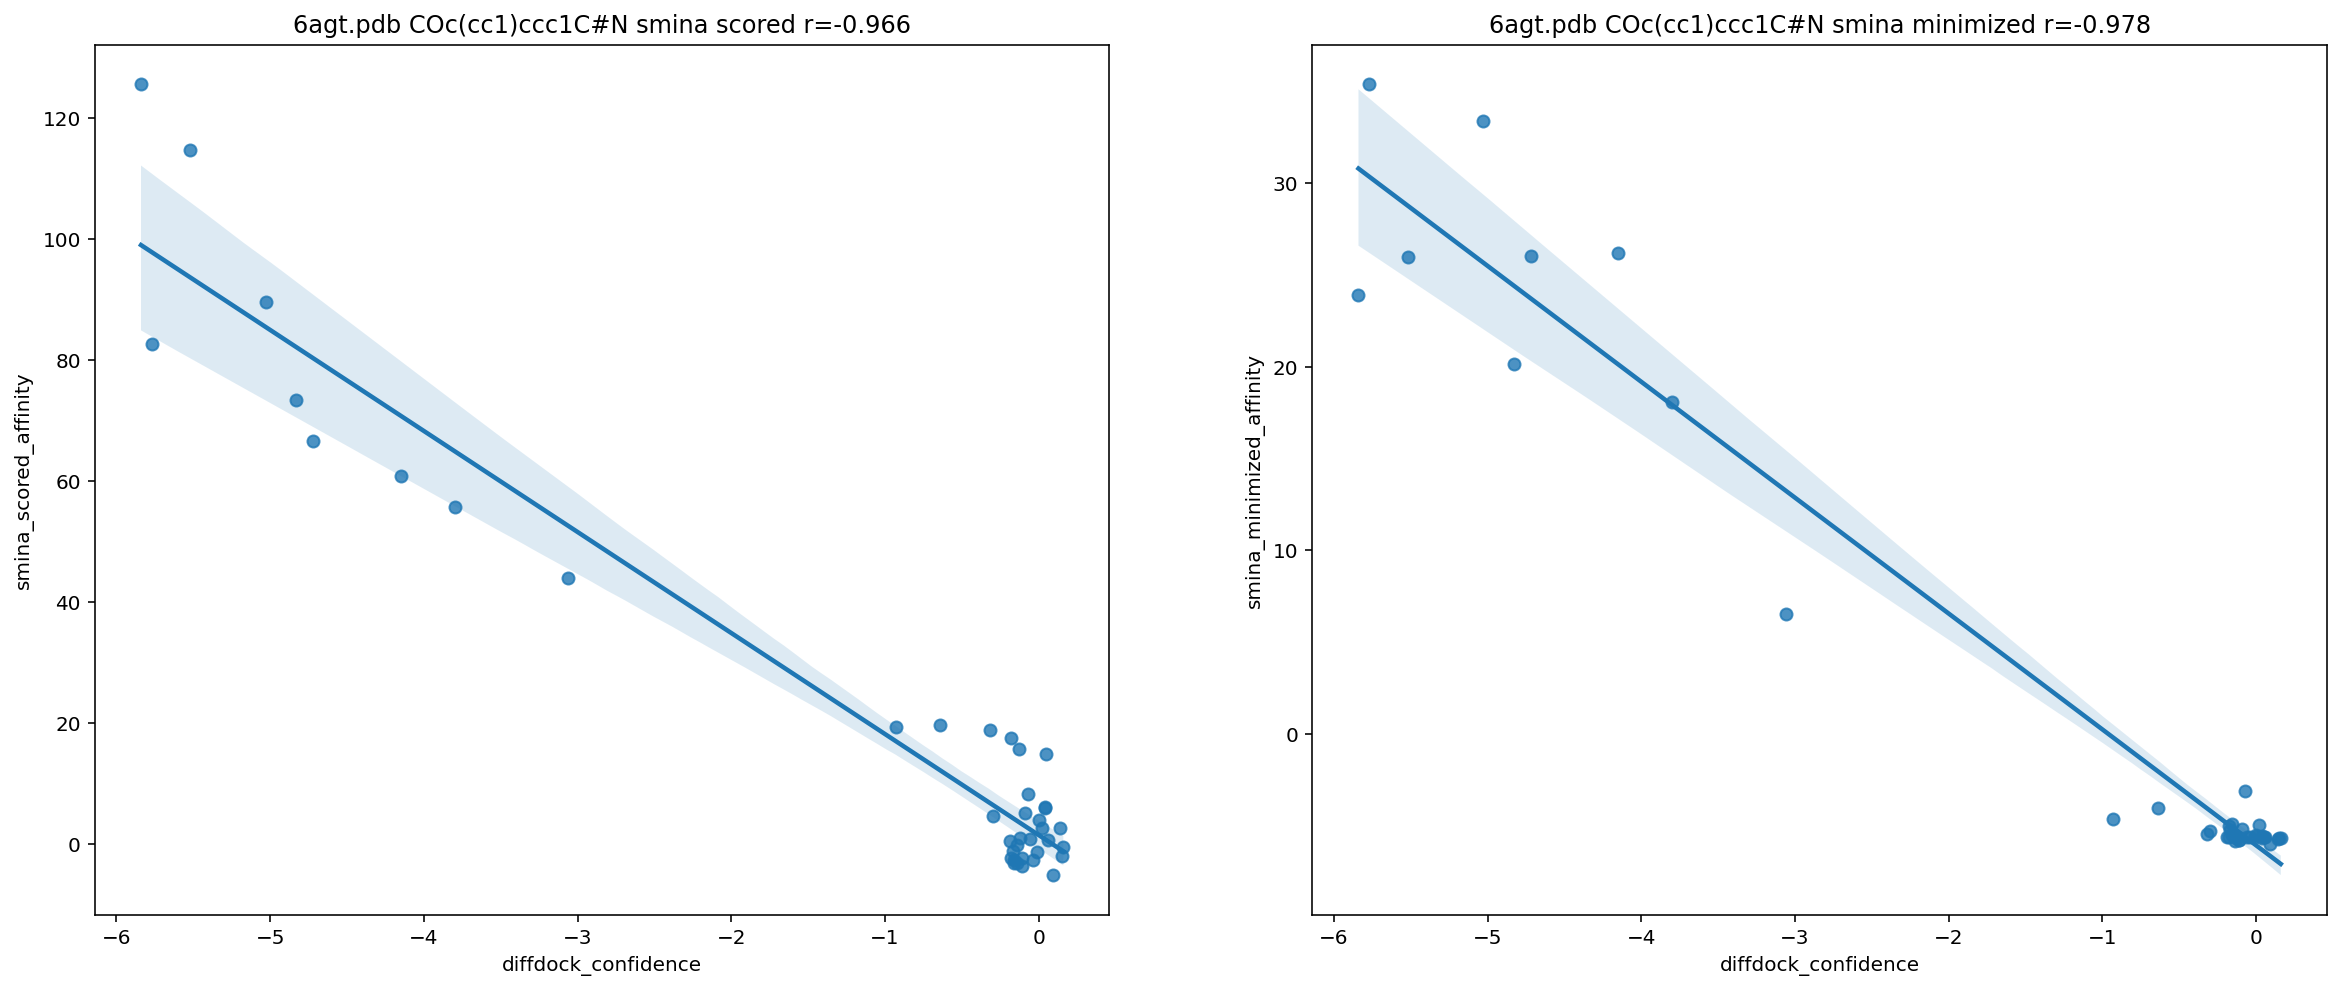

time: 1.04 s (started: 2022-12-18 14:01:18 +00:00)


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
%config InlineBackend.figure_format='retina'

for (pdb_file, smiles), df_group in df_results.groupby(["pdb_file", "smiles"]):
    f, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.regplot(data=df_group, x="diffdock_confidence", y="smina_scored_affinity", ax=ax[0]);
    sns.regplot(data=df_group, x="diffdock_confidence", y="smina_minimized_affinity", ax=ax[1]);

    slope, intercept, r_value_scored, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["smina_scored_affinity"])
    slope, intercept, r_value_minimized, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["smina_minimized_affinity"])
    ax[0].set_title(f"{pdb_file} {smiles[:30]} smina scored r={r_value_scored:.3f}");
    ax[1].set_title(f"{pdb_file} {smiles[:30]} smina minimized r={r_value_minimized:.3f}");

In [19]:
df_results.sort_values("diffdock_confidence", ascending=False)

,pdb_file,smiles,diffdock_confidence,smina_scored_affinity,smina_minimized_affinity,sdf_file
13,6agt.pdb,COc(cc1)ccc1C#N,0.16,-0.49517,-5.69726,./index0_-tmp-pdb-6agt.pdb____COc(cc1)ccc1C#N/...
36,6agt.pdb,COc(cc1)ccc1C#N,0.15,-1.95056,-5.70491,./index0_-tmp-pdb-6agt.pdb____COc(cc1)ccc1C#N/...
7,6agt.pdb,COc(cc1)ccc1C#N,0.14,2.65090,-5.71626,./index0_-tmp-pdb-6agt.pdb____COc(cc1)ccc1C#N/...
35,6agt.pdb,COc(cc1)ccc1C#N,0.09,-5.08227,-6.02839,./index0_-tmp-pdb-6agt.pdb____COc(cc1)ccc1C#N/...
1,6agt.pdb,COc(cc1)ccc1C#N,0.06,0.73372,-5.60848,./index0_-tmp-pdb-6agt.pdb____COc(cc1)ccc1C#N/...
22,6agt.pdb,COc(cc1)ccc1C#N,0.05,15.00065,-5.61986,./index0_-tmp-pdb-6agt.pdb____COc(cc1)ccc1C#N/...
3,6agt.pdb,COc(cc1)ccc1C#N,0.04,6.03437,-5.68292,./index0_-tmp-pdb-6agt.pdb____COc(cc1)ccc1C#N/...
17,6agt.pdb,COc(cc1)ccc1C#N,0.04,6.10877,-5.60298,./index0_-tmp-pdb-6agt.pdb____COc(cc1)ccc1C#N/...
34,6agt.pdb,COc(cc1)ccc1C#N,0.02,2.63692,-4.99603,./index0_-tmp-pdb-6agt.pdb____COc(cc1)ccc1C#N/...
0,6agt.pdb,COc(cc1)ccc1C#N,-0.00,3.98350,-5.54617,./index0_-tmp-pdb-6agt.pdb____COc(cc1)ccc1C#N/...


time: 37.4 ms (started: 2022-12-18 14:05:52 +00:00)
